# SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers

TL;DR

SegFormer is a semantic segmentation framework that combines Transformers with lightweight MLP decoders. It has a hierarchically structured Transformer encoder that outputs multiscale features without requiring positional encoding. The proposed MLP decoder aggregates information from different layers to render powerful representations, combining both local and global attention. SegFormer's simple and lightweight design is key to its efficient segmentation on Transformers.

- [Paper] : https://arxiv.org/pdf/2105.15203.pdf

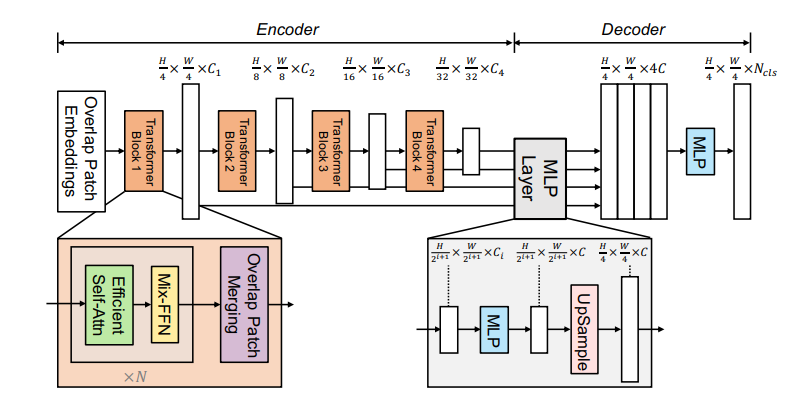

We use mmsegmentation in order to perform zero-shot learning on our data.

In [3]:
from mmseg.apis import inference_segmentor, init_segmentor
from collections import Counter
from glob import glob
import mmcv
import matplotlib.pyplot as plt
import numpy as np
import cv2
import warnings

# Ignore the warning
warnings.filterwarnings("ignore")

In [5]:
checkpoint_file = '../checkpoints/segformer_mit-b0_512x512_160k_ade20k_20220617_162207-c00b9603.pth'
config_file = '../configs/segformer_mit-b0_512x512_160k_ade20k.py'

# build the model from a config file and a checkpoint file
model = init_segmentor(config_file, checkpoint_file, device='cpu')

all_image_paths = glob('../data/natation/*.png')

load checkpoint from local path: ../checkpoints/segformer_mit-b0_512x512_160k_ade20k_20220617_162207-c00b9603.pth


In [6]:
def get_roi_segformer(model, img, crop_percent=0.05):
    """

    Get the Region of Interest (ROI) from a given image using a segmentation model.

    Args:
    - model: the segmentation model to use for obtaining the segmentation result.
    - img: the path to the input image file.
    - crop_percent: the percentage of the image to crop around the bounding box of the ROI.

    Returns:
    - image: the original image.
    - binary_image: the binary image obtained by setting pixels corresponding to regions of interest to 1.
    - mask: the segmentation mask of the ROI.
    - crop_img: the cropped ROI image.
    - size_reduction: the percentage reduction of the size of the ROI image compared to the original image.

    """
    
    # Load the image and obtain the segmentation result
    image = cv2.imread(img)
    result = inference_segmentor(model, img)

    # Define class and palette for better visualization
    classes = model.CLASSES
    palette = model.PALETTE

    # Obtain the segmentation mask and set pixels corresponding to regions of interest
    seg = result[0]
    binary_image = np.zeros((seg.shape[0], seg.shape[1]), dtype=np.uint8)
    classes_roi = {43}  # signboard
    #classes_roi = set(map(lambda x: x[0], Counter(seg.flatten()).most_common(5))) - {0}
    #print(classes_roi)
    # Plot the classes_roi with their corresponding palette color
    if len(classes_roi) == 1:
        for i, label in enumerate(classes_roi):
            class_name = classes[label]
            class_color = np.array(palette[label])/255.
            plt.imshow((seg == label).astype(np.uint8))
            plt.title(f'{class_name} ({label})', fontsize=12)
    else:
        fig, ax = plt.subplots(1, len(classes_roi), figsize=(10, 10))
        for i, label in enumerate(classes_roi):
            class_name = classes[label]
            class_color = np.array(palette[label])/255.
            ax[i].imshow((seg == label).astype(np.uint8))
            ax[i].set_title(f'{class_name} ({label})', fontsize=12)
            ax[i].set_axis_off()
            ax[i].set_facecolor(class_color)

    for label in classes_roi:
        binary_image[seg == label] = 1

    # Find connected components and obtain the biggest component (excluding background)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image)
    max_label = 1
    max_size = stats[1, cv2.CC_STAT_AREA]
    for i in range(2, num_labels):
        if stats[i, cv2.CC_STAT_AREA] > max_size:
            max_label = i
            max_size = stats[i, cv2.CC_STAT_AREA]

    # Create mask for biggest component and obtain its bounding box
    mask = (labels == max_label).astype(np.uint8)
    x, y, w, h = cv2.boundingRect(mask)

    # Crop the image to the bounding box and calculate the size reduction
    crop_width = int(image.shape[1] * crop_percent)
    crop_height = int(image.shape[0] * crop_percent)

    x += crop_width
    y += crop_height
    w -= 2 * crop_width
    h -= 2 * crop_height

    crop_img = image[y:y+h, x:x+w]

    size_reduction = 100 * w * h / np.prod(image.shape[0:2])
    print(f"Label with max area : {classes[max_label]} --- label : {max_label}")
    print(f"Size reduction new/original: {size_reduction:.2f}%")

    # Plot the original image, binary image, mask, and ROI image side by side
    fig, ax = plt.subplots(1, 4, figsize=(10, 10))
    ax[0].imshow(image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    ax[1].imshow(binary_image, cmap='gnuplot')
    ax[1].set_title('Binary Image')
    ax[1].axis('off')
    ax[2].imshow(mask, cmap='gnuplot')
    ax[2].set_title('Mask')
    ax[2].axis('off')
    ax[3].imshow(crop_img, cmap='gnuplot')
    ax[3].set_title('ROI Image')
    ax[3].axis('off')
    plt.show()

    # Return the original image, binary image, mask, and ROI image
    return image, binary_image, mask, crop_img, size_reduction

Label with max area : building --- label : 1
Size reduction new/original: 33.45%


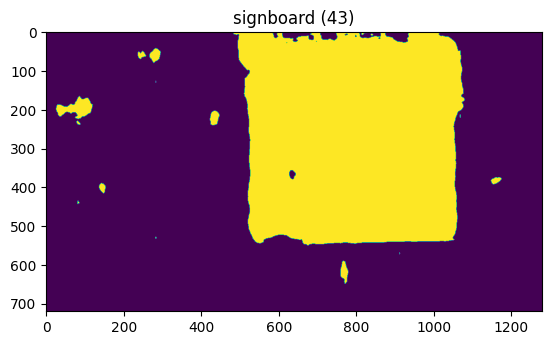

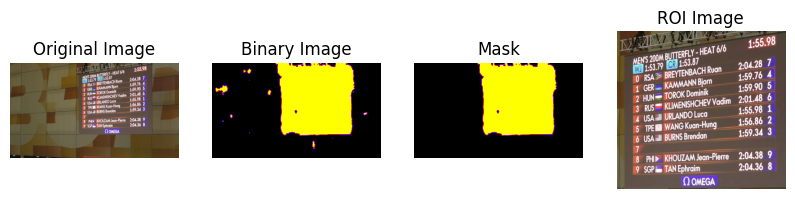

In [7]:
image, binary_image, mask, crop_img, size_reduction = get_roi_segformer(model, all_image_paths[14], crop_percent=0.01)

In [8]:
!mkdir ../data/natation/ROI/

mkdir: cannot create directory ‘../data/natation/ROI/’: File exists


Label with max area : sky --- label : 2
Size reduction new/original: 77.14%


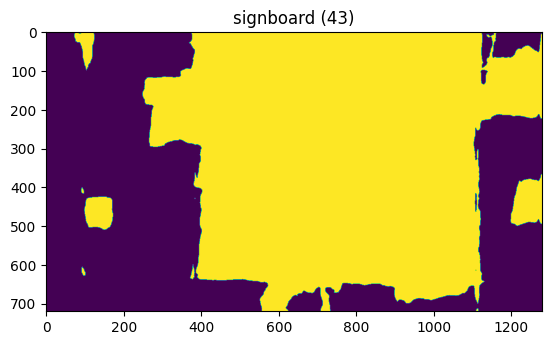

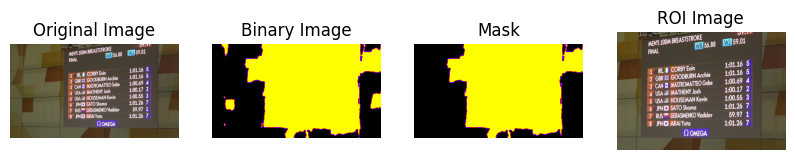

Label with max area : tree --- label : 4
Size reduction new/original: 69.50%


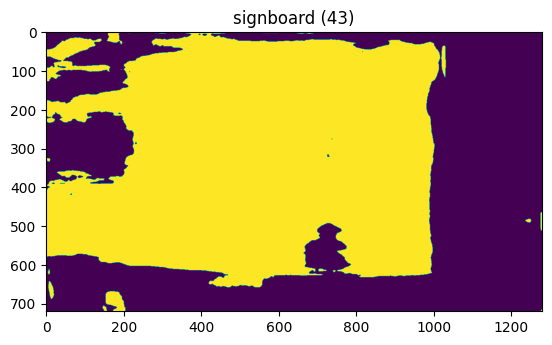

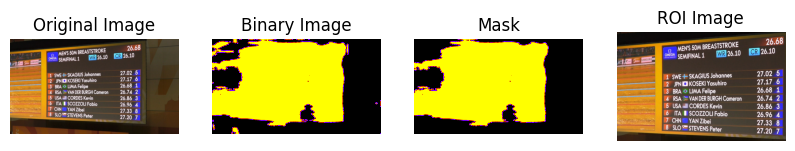

Label with max area : building --- label : 1
Size reduction new/original: 55.63%


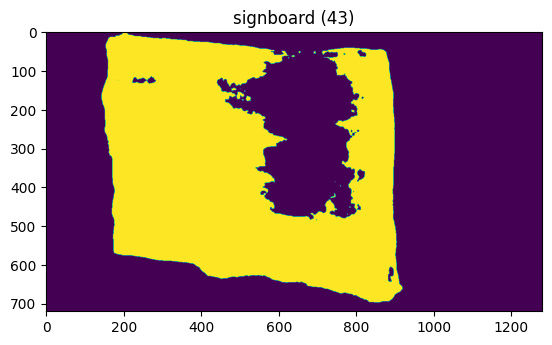

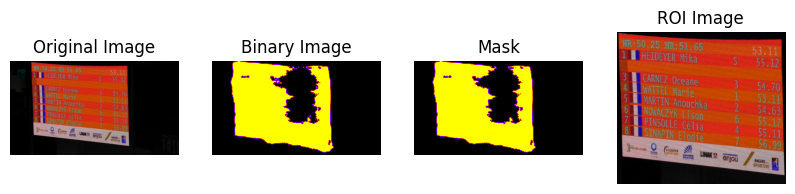

Label with max area : building --- label : 1
Size reduction new/original: 52.31%


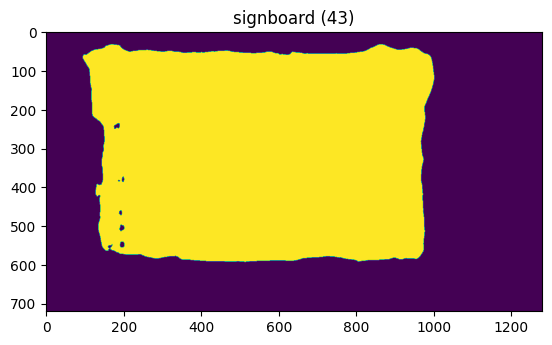

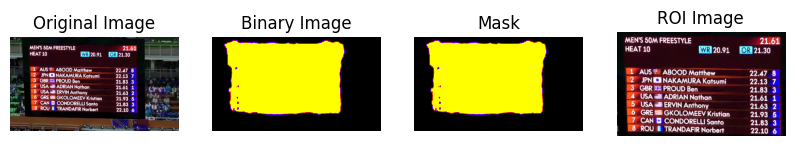

Label with max area : cabinet --- label : 10
Size reduction new/original: 16.98%


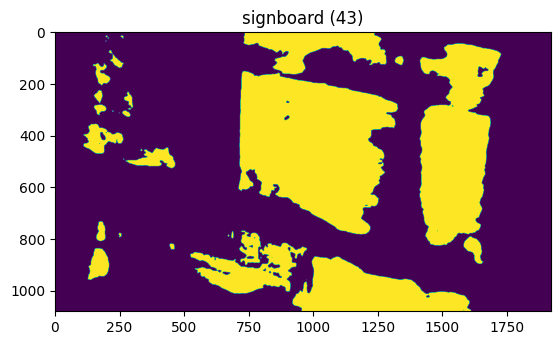

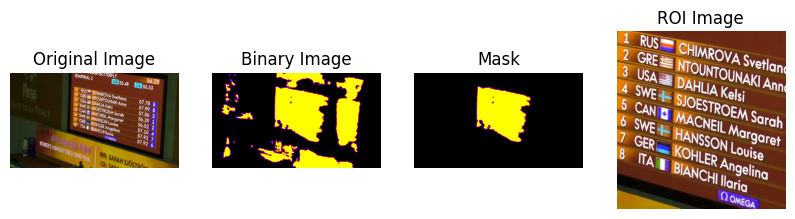

Label with max area : building --- label : 1
Size reduction new/original: 45.29%


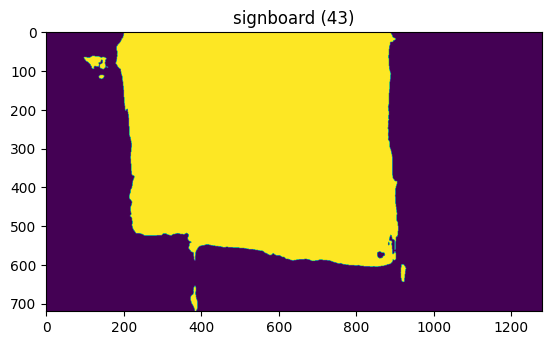

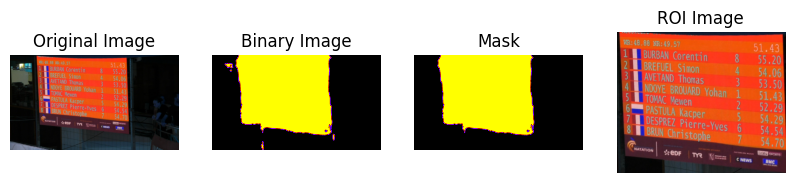

Label with max area : floor --- label : 3
Size reduction new/original: 27.83%


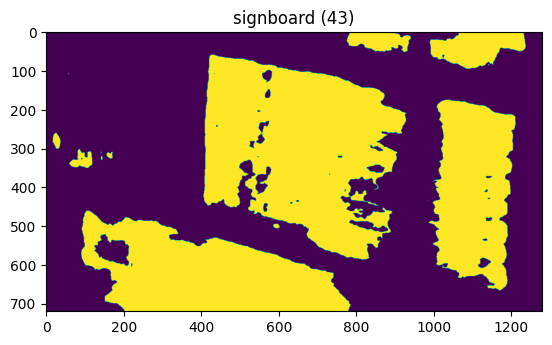

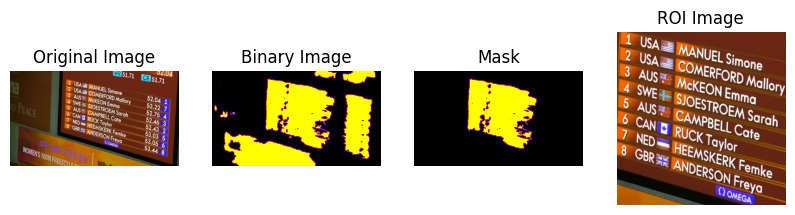

Label with max area : building --- label : 1
Size reduction new/original: 31.59%


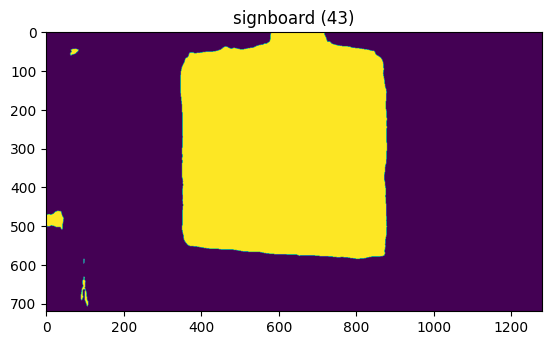

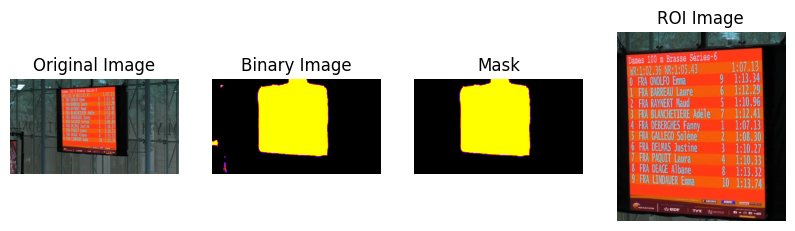

Label with max area : sky --- label : 2
Size reduction new/original: 53.33%


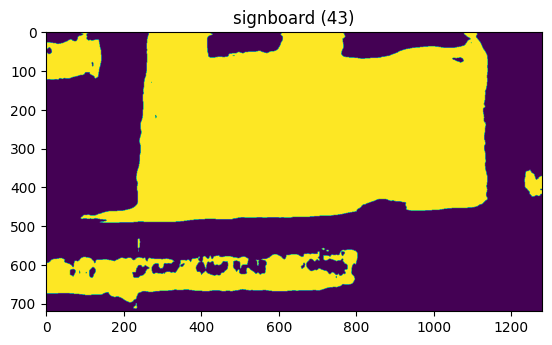

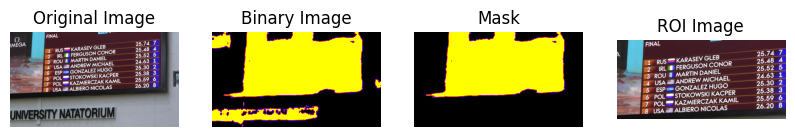

Label with max area : building --- label : 1
Size reduction new/original: 33.86%


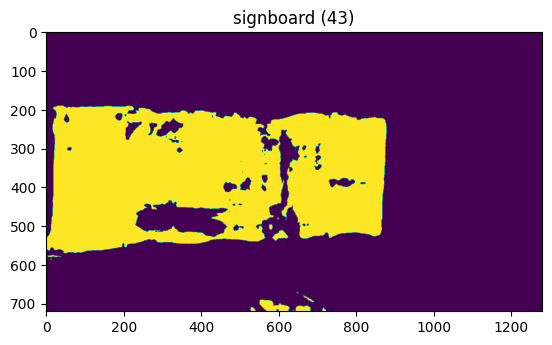

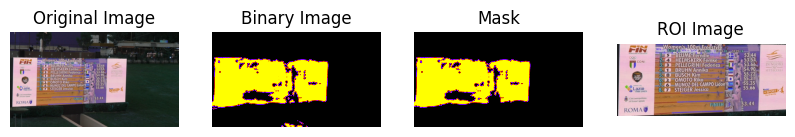

Label with max area : ceiling --- label : 5
Size reduction new/original: 39.81%


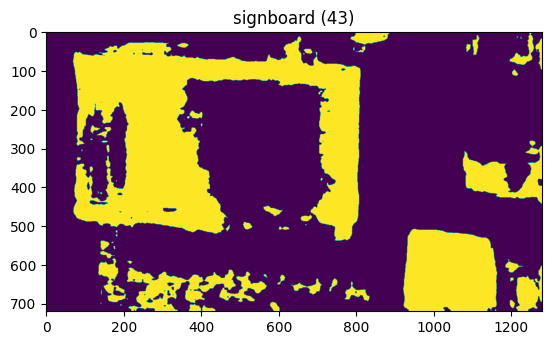

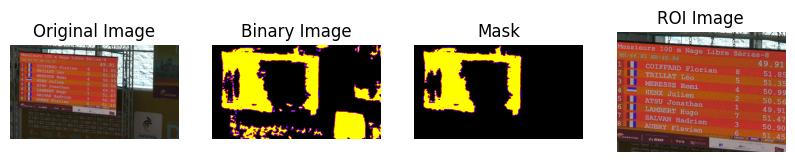

Label with max area : building --- label : 1
Size reduction new/original: 42.14%


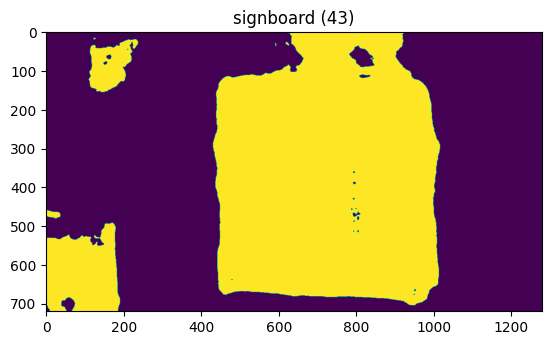

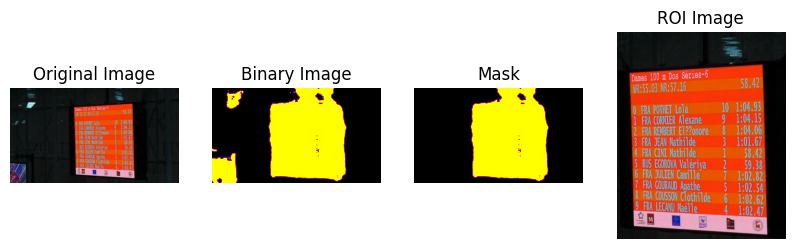

Label with max area : road --- label : 6
Size reduction new/original: 46.53%


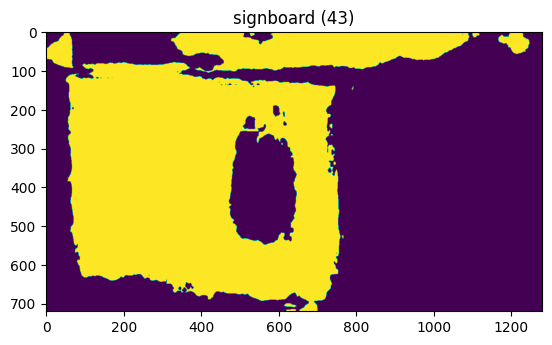

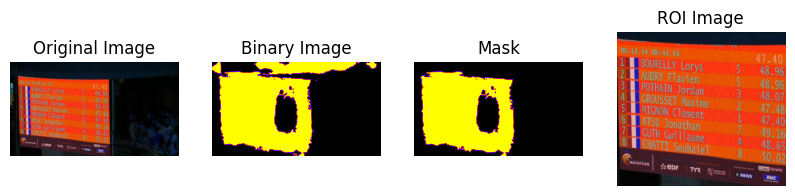

Label with max area : sky --- label : 2
Size reduction new/original: 53.93%


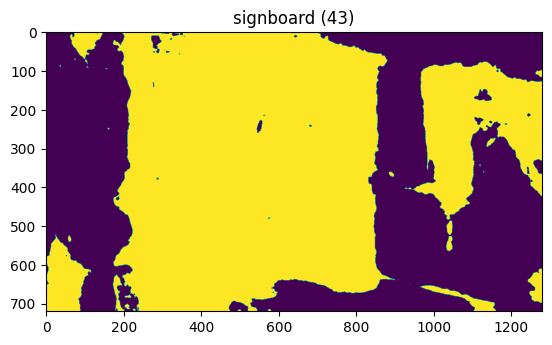

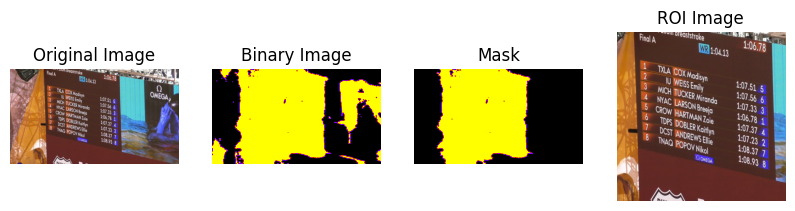

Label with max area : building --- label : 1
Size reduction new/original: 33.45%


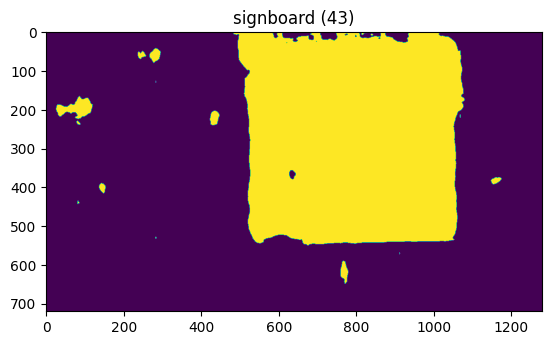

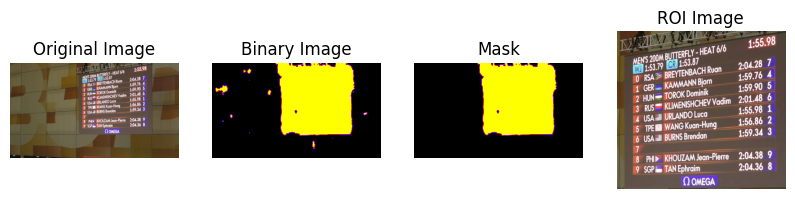

In [9]:
size_reductions = []

for img in all_image_paths:
    image, binary_image, mask, crop_img, size_reduction = get_roi_segformer(model, img, crop_percent=0.01)
    size_reductions.append(size_reduction)
    # Save the image to disk
    #cv2.imwrite("../data/natation/ROI/SegFormer/" + img.split("/")[-1], crop_img)

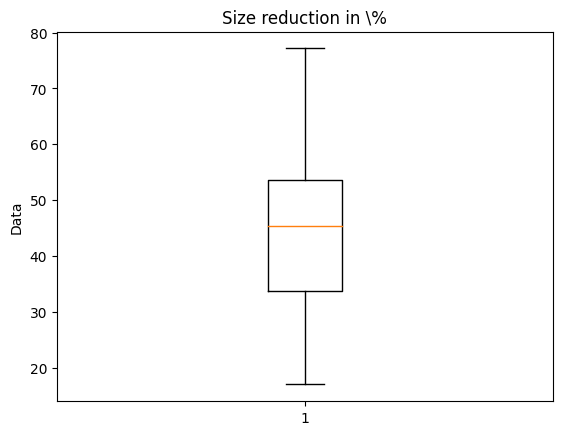

In [10]:
# plot boxplot
fig, ax = plt.subplots()
ax.boxplot(size_reductions)
ax.set_title('Size reduction in \%')
ax.set_ylabel('Data')
plt.show()